Classify star particles in the FIRE Milky Way simulation. We determine whether a star particle is accreted or formed in situ with its host galaxy.

We use the formation distance to determine whether a star particle is accreted. If the distance from a star particle to its host galaxy at the time of its formation is greater than 20 kpc. it is classified as accreted. 

In [1]:
import os
import h5py

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 6), facecolor='w')

import gizmo_analysis as gizmo

In [2]:
# create an output directory
os.makedirs('labels_mapping', exist_ok=True)

In [3]:
# set simulation directory to simulated galaxy
simulation_directory = '/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100'

# read star particles at redshift z=0
# setting assign_formation_coordinates=True to read formation coordinates of star particles
part = gizmo.io.Read.read_snapshots(
    ['star'], 'redshift', 0, simulation_directory,
    assign_formation_coordinates=True)


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gi

In [4]:
# get formation coordinates in Cartesian and calculate distance
form_distance = np.sqrt(np.sum(part['star']['form.host.distance']**2, 1))
max_form_distance = np.max(form_distance)
min_form_distance = np.min(form_distance)

print('Max formation distance: {:f}'.format(max_form_distance))
print('Min formation distance: {:f}'.format(min_form_distance))

Max formation distance: 2876.858154
Min formation distance: 0.000375


In [5]:
thres = 20    # set threshold to 20 kpc

mask_insitu = form_distance < thres
form_distance_insitu = form_distance[mask_insitu]
form_distance_accreted = form_distance[~mask_insitu]

n_insitu = len(form_distance_insitu)
n_accreted = len(form_distance_accreted)
n_total = len(form_distance)

print('Number of in situ star particles: {:d}'.format(n_insitu))
print('Number of accreted star particles: {:d}'.format(n_accreted))

print('Fraction of in situ star particles: {:4f}'.format(n_insitu / n_total))
print('Fraction of accreted star particles: {:4f}'.format(n_accreted / n_total))

Number of in situ star particles: 11551935
Number of accreted star particles: 2424550
Fraction of in situ star particles: 0.826526
Fraction of accreted star particles: 0.173474


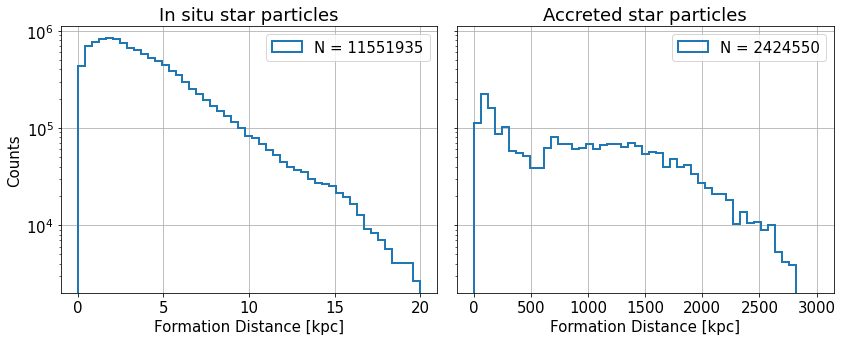

In [11]:
# plot histogram of formation distance for in situ and accreted stars separatedly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# hist for in situ stars
bins_insitu = np.linspace(0., 20, 50)
ax1.hist(form_distance_insitu, bins_insitu, 
         histtype='step', lw=2)

# hist for accreted stars
bins_accreted = np.linspace(0., 3000, 50)
ax2.hist(form_distance_accreted, bins_accreted, 
         histtype='step', lw=2)

# format axes and figure
for ax in (ax1, ax2):
    ax.set_xlabel('Formation Distance [kpc]')
    ax.set_yscale('log')
    ax.grid(True)

ax1.set_ylabel('Counts')
ax1.set_title('In situ star particles')
ax2.set_title('Accreted star particles')
ax1.legend(['N = {}'.format(n_insitu)])
ax2.legend(['N = {}'.format(n_accreted)])

fig.tight_layout()
fig.savefig('../figures/dataset_prop/formation_distance_particles.png', 
            bbox_inches='tight', dpi=300)

In [7]:
# create labels for in situ (0) and accreted stars (1)
labels = (~mask_insitu).astype(int)
id_stars = np.arange(len(labels), dtype=int)

# write output to HDF5 file
with h5py.File('labels_mapping/accreted_insitu.hdf5', 'w') as f:
    f.attrs.update({
        '0': 'insitu',
        '1': 'accreted',
        'formation_distance_threshold': thres,
    })
    f.create_dataset('id_stars', data=id_stars, chunks=True)
    f.create_dataset('labels', data=labels, chunks=True)
    f.create_dataset('form_distance', data=form_distance, chunks=True)